In [1]:

import os
os.environ['KAGGLE_USERNAME']="simransohal"
os.environ['KAGGLE_KEY']="3aa7697cd9a4ba2a3715c4a29c0f0cb6"

In [2]:
!kaggle datasets download -d mrgeislinger/asl-rgb-depth-fingerspelling-spelling-it-out

100% 2.11G/2.11G [01:10<00:00, 39.3MB/s]
100% 2.11G/2.11G [01:10<00:00, 32.2MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('asl-rgb-depth-fingerspelling-spelling-it-out.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.optim import Adam

import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time

In [5]:
d=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
ls

asl-rgb-depth-fingerspelling-spelling-it-out.zip  dataset5/  sample_data/


In [7]:
cd ..

/


In [8]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
data_dir="/content/dataset5"
data=datasets.ImageFolder(root=data_dir,transform=transforms)
data_loader=torch.utils.data.DataLoader(data)



In [9]:
# def get_mean_and_std(dataloader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in dataloader:
#         # Mean over batch, height and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#         num_batches += 1
    
#     mean = channels_sum / num_batches

#     # std = sqrt(E[X^2] - (E[X])^2)
#     std = (channels_squared_sum / num_batches - mean * 2) * 0.5

#     return mean, std

In [10]:
# mean,std=get_mean_and_std(data_loader)

In [11]:
# print(mean)
# print(std)

In [12]:
import torchvision.transforms as transforms
data_dir="/content/dataset5"
train_dir = "/content/train"
val_dir = "/content/validation"
test_dir = "/content/test"
train_size=0.8
test_size=0.2
validation_size=0.1

transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6463, 0.5908, 0.5900], std=[-0.3682, -0.3356, -0.3359]),
])
data=datasets.ImageFolder(root=data_dir,transform=transforms)
dataset_size=len(data)
train_data=int(train_size*dataset_size)
test_data=int(test_size*dataset_size)
validation_data=dataset_size-(train_data+test_data)
train,test,validation=td.random_split(data,[train_data,test_data,validation_data])
data_loader_train = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
data_loader_test  = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)
data_loader_val   = torch.utils.data.DataLoader(validation, batch_size=64, shuffle=True)



In [13]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64

In [14]:
!pip install torch torchvision --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from torchvision.models import shufflenet_v2_x1_0
import torchvision

d=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 24).to(d)
model=model.to(d)
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 135MB/s]


In [16]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(data_loader_train):
        optimizer.zero_grad()
        inputs = inputs.to(d)  
        labels = labels.to(d) 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader_train)}], Loss: {loss.item()}')
        _, preds = torch.max(outputs, 1)
        running_training_accuracy += torch.sum(preds == labels.data)
    
    epoch_training_loss = running_training_loss / len(data_loader_train)
    epoch_training_accuracy = running_training_accuracy / len(data_loader_train.dataset)
    training_loss.append(epoch_training_loss)
    training_accuracy.append(epoch_training_accuracy)
    
    running_validation_loss = 0.0
    running_validation_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader_val):
            inputs = inputs.to(d)  
            labels = labels.to(d)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_validation_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_validation_accuracy += torch.sum(preds == labels.data)
    
    epoch_validation_loss = running_validation_loss / len(data_loader_val)
    epoch_validation_accuracy = running_validation_accuracy / len(data_loader_val.dataset)
    validation_loss.append(epoch_validation_loss)
    validation_accuracy.append(epoch_validation_accuracy)
    print('Epoch [{}/{}], Training Loss: {}, Training Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
          .format(epoch+1, num_epochs, epoch_training_loss, epoch_training_accuracy, epoch_validation_loss, epoch_validation_accuracy))
     


Epoch [1/10], Step [100/1646], Loss: 0.7159630656242371
Epoch [1/10], Step [200/1646], Loss: 0.5139226913452148
Epoch [1/10], Step [300/1646], Loss: 0.5679211616516113
Epoch [1/10], Step [400/1646], Loss: 0.3850020170211792
Epoch [1/10], Step [500/1646], Loss: 0.29828718304634094
Epoch [1/10], Step [600/1646], Loss: 0.43039605021476746
Epoch [1/10], Step [700/1646], Loss: 0.3194675147533417
Epoch [1/10], Step [800/1646], Loss: 0.24076399207115173
Epoch [1/10], Step [900/1646], Loss: 0.1997605711221695
Epoch [1/10], Step [1000/1646], Loss: 0.35211431980133057
Epoch [1/10], Step [1100/1646], Loss: 0.279169499874115
Epoch [1/10], Step [1200/1646], Loss: 0.27189967036247253
Epoch [1/10], Step [1300/1646], Loss: 0.3647194504737854
Epoch [1/10], Step [1400/1646], Loss: 0.3871367871761322
Epoch [1/10], Step [1500/1646], Loss: 0.24209490418434143
Epoch [1/10], Step [1600/1646], Loss: 0.40446972846984863
Epoch [1/10], Training Loss: 0.4233606895239501, Training Accuracy: 0.8372699618339539, Val

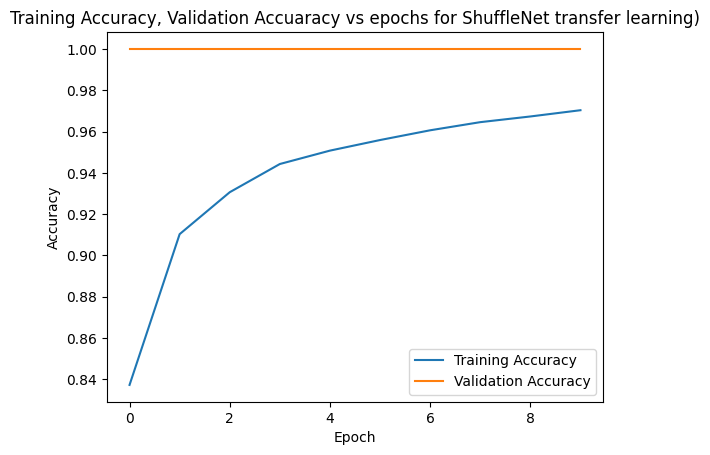

In [20]:


training_accuracy_tensor = torch.tensor(training_accuracy)
validation_accuracy_tensor = torch.tensor(validation_accuracy)

plt.plot(training_accuracy_tensor.to('cpu'), label='Training Accuracy')
plt.plot(validation_accuracy_tensor.to('cpu'), label='Validation Accuracy')
plt.title('Training Accuracy, Validation Accuaracy vs epochs for ShuffleNet transfer learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
     


Test Accuracy: 0.966202103824099
[[4949   11   35   10   19]
 [  23 5287  297   14   28]
 [  38  225 4995   13   58]
 [   6    5    4 5298   58]
 [   5   12   10   19 4914]]


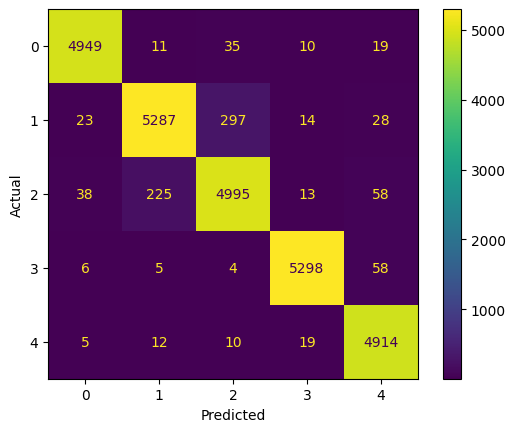

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5024
           1       0.95      0.94      0.95      5649
           2       0.94      0.94      0.94      5329
           3       0.99      0.99      0.99      5371
           4       0.97      0.99      0.98      4960

    accuracy                           0.97     26333
   macro avg       0.97      0.97      0.97     26333
weighted avg       0.97      0.97      0.97     26333



In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import torch
import torchvision.models as models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []
    for inputs, labels in data_loader_test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.tolist())
        test_labels.extend(labels.tolist())

test_acc = accuracy_score(test_labels, test_preds)
print('Test Accuracy: {}'.format(test_acc))

#target_names = list(data_loader_train.class_to_idx.keys())
cm = confusion_matrix(test_labels, test_preds)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
#sns.heatmap(cm, annot=True, cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, test_preds))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 26333 samples in 0.463s...
[t-SNE] Computed neighbors for 26333 samples in 912.820s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26333
[t-SNE] Computed conditional probabilities for sample 2000 / 26333
[t-SNE] Computed conditional probabilities for sample 3000 / 26333
[t-SNE] Computed conditional probabilities for sample 4000 / 26333
[t-SNE] Computed conditional probabilities for sample 5000 / 26333
[t-SNE] Computed conditional probabilities for sample 6000 / 26333
[t-SNE] Computed conditional probabilities for sample 7000 / 26333
[t-SNE] Computed conditional probabilities for sample 8000 / 26333
[t-SNE] Computed conditional probabilities for sample 9000 / 26333
[t-SNE] Computed conditional probabilities for sample 10000 / 26333
[t-SNE] Computed conditional probabilities for sample 11000 / 26333
[t-SNE] Computed conditional probabilities for sample 12000 / 26333
[t-SNE] Computed conditional probabilities for s

<ipython-input-22-10c55e74ae6f>:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(target_names))
<ipython-input-22-10c55e74ae6f>:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))
<ipython-input-22-10c55e74ae6f>:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use t

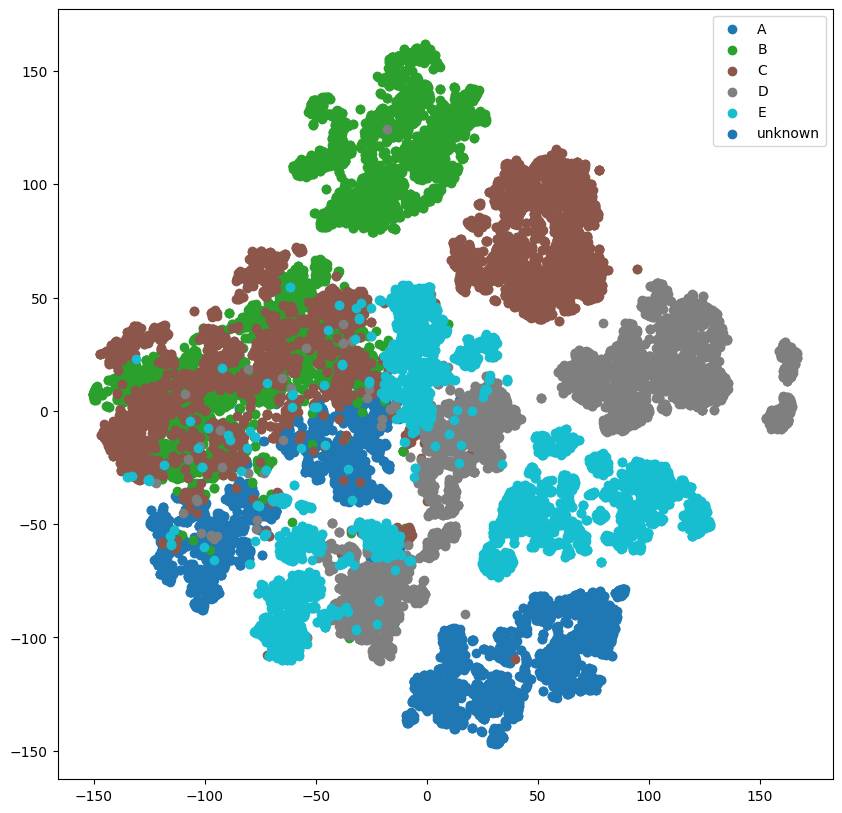

In [22]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import torchvision.models as models


device = torch.device('cuda')

model.to(device)

new_model = torch.nn.Sequential(*(list(model.children())[:-1]))

new_model.eval()

features = []
labels = []
for images, target in data_loader_test:
    images = images.to(device)
    with torch.no_grad():
        output = new_model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# reshape the features array to have two dimensions
n_samples = features.shape[0]
n_features = np.prod(features.shape[1:])
features = features.reshape((n_samples, n_features))

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names = list(data.class_to_idx.keys())

cmap = plt.cm.get_cmap('tab10', len(target_names))

u = labels == -1

plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    indices = labels == i
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))
plt.scatter(tsne_features[u, 0], tsne_features[u, 1], label="unknown", c=cmap(-1))
plt.legend()
plt.show()
